# Using Machine Learning Classifiers In Julia To Improve The Retention Rate Of Community College Students

## Introduction

By Clarman Cruz

March 2020

Years ago, I had the opportunity to go to the university even though I had very low standardized test scores.  The State University of New York saw more than standardized tests on me.  My university accepted me by looking at other factors and correctly predicting I was going to complete the Bachelor Degree and Master Degree.  I have always been grateful for that. And, I have been paying city, state and federal taxes ever since completing the degrees..       

Community colleges in the United States are using data analytics in their admission process.  The community colleges are in the hunt to find students with great potential but who might not have great grades in high school.  One example is the project described in  https://www.sas.com/en_us/customers/des-moines-area-community-college.html  “Des Moines Area Community College uses analytics and data visualization to help students prosper in the classroom and beyond.  ... DMACC is using analytics and data visualization from SAS to access, integrate and manage data to help improve student enrollment, retention and graduation rates."

There are three main sections of this jupyter lab.  One section is the "Before Entering the Community College."  The second section is the "While Attending the Community College."  The third section is the "After Graduating from the Community College."  There is a Julia machine learning model per section.  The three machine learning classifiers are chained to another.  It is the author's original modeling design.   The output of [K means](https://juliastats.org/Clustering.jl/stable/kmeans.html) model is the input of the binary [Support Vector Machine](https://www.csie.ntu.edu.tw/~cjlin/libsvm) model.  The output of the binary Support Vector Machine model is the input of the [Random Forrest](https://pkg.julialang.org/docs/DecisionTree/pEDeB/0.8.1) model.  The results of the Random Forest model in turn aid to improve the previous model.  The three machine learning classifiers guide a community college improve their service to students increasing the retention rate.

In this jupyter lab, we assume the data is available for the machine learning models.  The kind of education information involved in this lab is personal and not available to the general public.  Therefore, we randomly create our datasets here.  Yes, random data is far from real educational information.  However, the emphasis here is the implementation of machine learning models, and how we use them to better retain community college students.  

## MLJ Julia Package

This jupyter lab is in [Julia](https://julialang.org) 1.31.  The machine learning models are implemented using the [MLJ](https://alan-turing-institute.github.io/MLJTutorials) Julia package.  The MLJ package is a very good machine learning framework.  The [Alan Turing Institute](https://www.turing.ac.uk) sponsors the package and MLJ supports most of the machine learning models in Julia.  MLJ "offers a consistent way to use, compose and tune machine learning models in Julia.  ... MLJ unlocks performance gains by exploiting Julia's support for parallelism, automatic differentiation, GPU, optimisation etc."  The MLJ Julia package is well documented and easy to use.  It allows model tuning, fit, predict, and transform.  

In [1]:
using MLJ, Random, DataFrames, Queryverse, Statistics, CategoricalArrays, PrettyPrinting
@load KMeans pkg = Clustering
@load PCA    pkg = MultivariateStats
@load SVC    pkg = LIBSVM
@load RandomForestClassifier pkg=DecisionTree

RandomForestClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    n_trees = 10,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0) @ 1…17

## Before Entering the Community College

The admission office needs a way to classify the high school students who are applying to the community college. Let's give them a machine learning model to do so.  We need a machine learning model that is easy to understand.  Also, the model should be easy to share among community college staff and high school administrators. A model that is graphically visual would be best.  K means is a great machine learning classifier because it is easy to interpret graphically.  

Let us assume that the community college has a strong relationship with the local high schools.  The high schools are collecting data on their students and sharing with the community college.  The first step for the community college is to clean up the collected high school data.  Delete any duplicated rows or rows with more than 70% missing values.   Delete any columns with more than 75% missing values.  Find any outliers in the numerical values, fix typos in string data, and ensure the categorical values are consistent within range.  Use mean or use regression with perturbation to impute values for the missing data.  Create some graphs to visualize the high school data.  Usually visualizations show outliers, data patterns, improper categories, or data inconsistencies. 

As stated before, due to privacy, we are making up the datasets in this lab.  Let us assume all of the the parents of the high school students have at least a GED because in the United States and Canada there is a law to provide K12 education to all students.  Wikipedia explains that "The General Educational Development (GED) tests are a group of four subject tests which, when passed, provide certification that the test taker has United States or Canadian high school-level academic skills."  We assume that parents with Master degrees are more likely to be employed than parents without a Master degree.  Do you agree with both assumptions?

The K means model is efficient, and flexible. The K means classifier works best for numerical data because the algorithm computes a distance between data points.  We convert any categorical data to a number by converting categorical values to a set of binary values called one-hot-encoders.  Here, parents' employment status and single family become binary 0 or 1.  Let the parent’s education level be the highest grade completed by one of the parents.  For example, 16 is a Bachelor degree and 18 is a Master Degree.  The hobbies are a scale from 1 to 10 where 1 is low activity and 10 is high activity.  

In addition, we must normalize our data before we fit it to K means model and other machine learning models.  The result of normalization is to scale the original values to a range between 0 and 1.  We let the MLJ compute the [PCA](https://multivariatestatsjl.readthedocs.io/en/stable/index.html) and the normalization for us.  

Now it is time to create the random data set.  


In [2]:
const nStudents = 1000
dfHighSchoolStudents = DataFrame(
    ParentsEducationLevel = Int[], 
    ParentsEmploymentStatus = Int[],
    SingleParentFamily = Int[],
    ZipCode = Int[],
    SiblingsInCollege = Int[],
    AbsentDays = Int[],
    TotalSchoolGrade = Int[],
    StandardizedTestScore = Int[],
    MathAverageGrade = Int[],
    ScienceAverageGrade = Int[],
    ReadingAverageGrade = Int[],
    WritingAverageGrade = Int[],
    CookingHobby = Int[],
    SportsHobby = Int[],
    MusicHobby = Int[],
    CommunityService = Int[],
    SocialMedia = Int[]
)
Random.seed!(20200226)
for s in 1:nStudents
    ParentsEducationLevel = rand(12:12+4+2+4) # K12 + Bachelor + Master + Doctorate
    ParentsEmploymentStatus = rand(0:1)
    if ParentsEducationLevel > 12+4+2  && ParentsEmploymentStatus == 0 
        ParentsEmploymentStatus = rand(0:1)
    end 
    SingleParentFamily = rand(0:1)
    ZipCode = rand(1:5)
    SiblingsInCollege = rand(0:4)
    AbsentDays = rand(0:13)
    TotalSchoolGrade = rand(50:100)
    StandardizedTestScore = rand(30:100)
    MathAverageGrade = rand(50:100)
    ScienceAverageGrade = rand(50:100)
    ReadingAverageGrade = rand(50:100)
    WritingAverageGrade = rand(50:100)
    CookingHobby = rand(1:10)
    SportsHobby = rand(1:10)
    MusicHobby = rand(1:10)
    CommunityService = rand(1:10)
    SocialMedia = rand(1:10)
    
    push!(dfHighSchoolStudents, 
        (ParentsEducationLevel,
        ParentsEmploymentStatus,  
        SingleParentFamily,  
        ZipCode,
        SiblingsInCollege,
        AbsentDays,
        TotalSchoolGrade,
        StandardizedTestScore,
        MathAverageGrade,
        ScienceAverageGrade,
        ReadingAverageGrade,
        WritingAverageGrade,
        CookingHobby,
        SportsHobby,
        MusicHobby,
        CommunityService,
        SocialMedia)
    )
end 

dfHighSchoolStudents |> @filter(_.SingleParentFamily == 1)

ParentsEducationLevel,ParentsEmploymentStatus,SingleParentFamily,ZipCode,SiblingsInCollege,AbsentDays,TotalSchoolGrade,StandardizedTestScore,MathAverageGrade,ScienceAverageGrade,ReadingAverageGrade,WritingAverageGrade,CookingHobby,SportsHobby,MusicHobby,CommunityService,SocialMedia
20,1,1,5,4,9,70,61,96,96,68,76,9,7,5,1,5
17,1,1,2,4,10,65,97,94,100,81,51,7,9,2,10,5
13,1,1,1,2,5,70,78,67,71,88,87,3,2,3,6,5
17,1,1,5,1,1,54,87,70,97,78,89,4,7,1,9,5
19,1,1,1,1,11,51,31,59,90,97,63,7,1,6,6,10
16,1,1,2,0,4,56,52,96,89,93,71,10,6,7,10,1
20,1,1,5,0,10,97,59,97,88,63,97,10,1,9,8,6
22,1,1,2,3,10,94,91,73,85,67,93,9,5,9,4,1
17,0,1,1,2,4,80,37,71,70,93,88,5,10,8,10,1
21,0,1,1,0,5,55,74,84,62,94,84,1,5,3,7,2


And, let us define the scientific types for each column.  It is important that the machine learning algorithm handles our data correctly.  Each column is given a business-interpretation. 

In [3]:
dfHighSchoolStudentsScientific = coerce(dfHighSchoolStudents, 
    :ParentsEducationLevel   => OrderedFactor,
    :ParentsEmploymentStatus => OrderedFactor,
    :SingleParentFamily      => OrderedFactor,
    :ZipCode                 => OrderedFactor,
    :SiblingsInCollege       => Count,
    :AbsentDays              => Count,             
    :TotalSchoolGrade        => Continuous,    
    :StandardizedTestScore   => Continuous,  
    :MathAverageGrade        => Continuous,       
    :ScienceAverageGrade     => Continuous,  
    :ReadingAverageGrade     => Continuous,   
    :WritingAverageGrade     => Continuous,    
    :CookingHobby            => Count,  
    :SportsHobby             => Count,            
    :MusicHobby              => Count,     
    :CommunityService        => Count,         
    :SocialMedia             => Count              
)

dfHighSchoolStudentsScientific |> @filter(_.SingleParentFamily == 1)

ParentsEducationLevel,ParentsEmploymentStatus,SingleParentFamily,ZipCode,SiblingsInCollege,AbsentDays,TotalSchoolGrade,StandardizedTestScore,MathAverageGrade,ScienceAverageGrade,ReadingAverageGrade,WritingAverageGrade,CookingHobby,SportsHobby,MusicHobby,CommunityService,SocialMedia
"CategoricalValue{Int64,UInt32} 20 (9/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 5 (5/5)",4,9,70.0,61.0,96.0,96.0,68.0,76.0,9,7,5,1,5
"CategoricalValue{Int64,UInt32} 17 (6/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 2 (2/5)",4,10,65.0,97.0,94.0,100.0,81.0,51.0,7,9,2,10,5
"CategoricalValue{Int64,UInt32} 13 (2/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",2,5,70.0,78.0,67.0,71.0,88.0,87.0,3,2,3,6,5
"CategoricalValue{Int64,UInt32} 17 (6/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 5 (5/5)",1,1,54.0,87.0,70.0,97.0,78.0,89.0,4,7,1,9,5
"CategoricalValue{Int64,UInt32} 19 (8/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",1,11,51.0,31.0,59.0,90.0,97.0,63.0,7,1,6,6,10
"CategoricalValue{Int64,UInt32} 16 (5/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 2 (2/5)",0,4,56.0,52.0,96.0,89.0,93.0,71.0,10,6,7,10,1
"CategoricalValue{Int64,UInt32} 20 (9/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 5 (5/5)",0,10,97.0,59.0,97.0,88.0,63.0,97.0,10,1,9,8,6
"CategoricalValue{Int64,UInt32} 22 (11/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 2 (2/5)",3,10,94.0,91.0,73.0,85.0,67.0,93.0,9,5,9,4,1
"CategoricalValue{Int64,UInt32} 17 (6/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",2,4,80.0,37.0,71.0,70.0,93.0,88.0,5,10,8,10,1
"CategoricalValue{Int64,UInt32} 21 (10/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",0,5,55.0,74.0,84.0,62.0,94.0,84.0,1,5,3,7,2


Very quickly, we are ready to use K means to classify the high school students who are applying to the community college. K means clustering with K = 4.  The four clusters are “strong” students,  “good” students, “fair” students, and “at-risk” students.  The main and only emphasis is not standardized scores and high school total grade.  About 85% of the variance is explained with 7 PCA dimensions.   

In [4]:
@pipeline SPCA(std  = Standardizer(),
                pca = PCA(),
                hot = OneHotEncoder(),
                km  = KMeans(k=4))
X = dfHighSchoolStudentsScientific
pipe = SPCA()
Kmeans = machine(pipe, X)
fit!(Kmeans)

assignments = report(Kmeans).reports[1].assignments
r  = report(Kmeans).reports[3]  # 2 or 3
cs = cumsum(r.principalvars ./ r.tvar)

println("Cumulative Variance Explained: ", cs, "\n")
fitted_params(Kmeans) |> pprint

┌ Info: Training Machine{SPCA} @ 1…62.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{Standardizer} @ 1…82.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{PCA} @ 9…00.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{OneHotEncoder} @ 1…58.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{KMeans} @ 1…44.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


Cumulative Variance Explained: [0.21195755419880138, 0.34714427944422566, 0.4629380319770855, 0.5746895043024887, 0.6764122341734474, 0.7734328544476086, 0.8680067749233511, 0.8935412775594542, 0.918093973065291, 0.9318629078121586, 0.9447647423888965, 0.9575541468691517, 0.9701972033151098, 0.9823619143028862, 0.9938952830410496]

(machines = [NodalMachine{KMeans} @ 1…44,
             NodalMachine{OneHotEncoder} @ 1…58,
             NodalMachine{PCA} @ 9…00,
             NodalMachine{Standardizer} @ 1…82],
 fitted_params =
     [(centers =
           [2.7967006919677027 3.6764115350859754 -3.0729941067675783 -4.2501311737248555; 3.1257240927607084 -2.666614291871912 -0.061289629988454185 -0.34197286404930627; 0.7096295137008346 -0.4365871594607604 -1.9670008266306038 1.6111942263745853; 0.3922936762259613 -0.23281986744114586 -1.0202372662102002 0.8164321587551441; -0.04734844796540524 -0.2144719298503529 1.4897370241477343 -1.1396407932025654; -0.14609041531503342 -0.2497406780823167

Next, the cluster assignments from the K mean model are mapped to the high school students.  Afterwards, we graph the classification.  We can easily add more graphs for the community college administrators.  The [VegaLite](https://www.queryverse.org/VegaLite.jl/stable) is used as the Julia graphing package.  

In [5]:
dfHighSchoolStudentsKmeans = copy(dfHighSchoolStudentsScientific)
dfHighSchoolStudentsKmeans.KMeans = categorical(assignments)

dfHighSchoolStudentsKmeans[!,:Hobby_mean] = (dfHighSchoolStudentsKmeans[!,:CookingHobby] + dfHighSchoolStudentsKmeans[!,:SportsHobby] + dfHighSchoolStudentsKmeans[!,:MusicHobby])/3.0 
dfHighSchoolStudentsKmeans[!,:Social_mean] = (dfHighSchoolStudentsKmeans[!,:CommunityService] + dfHighSchoolStudentsKmeans[!,:SocialMedia])/2.0 

dfHighSchoolStudentsKmeans |> @filter(_.KMeans == 1)

ParentsEducationLevel,ParentsEmploymentStatus,SingleParentFamily,ZipCode,SiblingsInCollege,AbsentDays,TotalSchoolGrade,StandardizedTestScore,MathAverageGrade,ScienceAverageGrade,ReadingAverageGrade,WritingAverageGrade,CookingHobby,SportsHobby,MusicHobby,CommunityService,SocialMedia,KMeans,Hobby_mean,Social_mean
"CategoricalValue{Int64,UInt32} 17 (6/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 2 (2/5)",4,10,65.0,97.0,94.0,100.0,81.0,51.0,7,9,2,10,5,"CategoricalValue{Int64,UInt32} 1",6.0,7.5
"CategoricalValue{Int64,UInt32} 12 (1/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 4 (4/5)",1,5,55.0,71.0,74.0,97.0,72.0,89.0,7,3,3,5,5,"CategoricalValue{Int64,UInt32} 1",4.33333,5.0
"CategoricalValue{Int64,UInt32} 13 (2/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",1,13,76.0,61.0,75.0,89.0,94.0,64.0,10,9,7,5,6,"CategoricalValue{Int64,UInt32} 1",8.66667,5.5
"CategoricalValue{Int64,UInt32} 12 (1/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 3 (3/5)",0,10,58.0,76.0,54.0,54.0,63.0,92.0,3,4,7,5,2,"CategoricalValue{Int64,UInt32} 1",4.66667,3.5
"CategoricalValue{Int64,UInt32} 14 (3/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",1,9,57.0,30.0,99.0,69.0,63.0,87.0,6,9,9,4,1,"CategoricalValue{Int64,UInt32} 1",8.0,2.5
"CategoricalValue{Int64,UInt32} 15 (4/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 4 (4/5)",2,10,73.0,39.0,87.0,81.0,87.0,56.0,6,8,4,7,2,"CategoricalValue{Int64,UInt32} 1",6.0,4.5
"CategoricalValue{Int64,UInt32} 17 (6/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 4 (4/5)",1,9,57.0,45.0,84.0,63.0,77.0,98.0,7,5,1,7,8,"CategoricalValue{Int64,UInt32} 1",4.33333,7.5
"CategoricalValue{Int64,UInt32} 15 (4/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 1 (1/5)",1,8,70.0,69.0,86.0,95.0,51.0,89.0,2,2,2,7,3,"CategoricalValue{Int64,UInt32} 1",2.0,5.0
"CategoricalValue{Int64,UInt32} 15 (4/11)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 5 (5/5)",1,13,87.0,77.0,53.0,58.0,91.0,53.0,3,8,9,4,5,"CategoricalValue{Int64,UInt32} 1",6.66667,4.5
"CategoricalValue{Int64,UInt32} 15 (4/11)","CategoricalValue{Int64,UInt32} 1 (2/2)","CategoricalValue{Int64,UInt32} 0 (1/2)","CategoricalValue{Int64,UInt32} 2 (2/5)",3,13,88.0,63.0,93.0,92.0,58.0,89.0,3,4,4,9,2,"CategoricalValue{Int64,UInt32} 1",3.66667,5.5


Now we graph the classification.  Typically, the K means graphs are just two dimensions.  Here, we graph an extension of the typical K means graph adding more factors.  We can easily add more graphs for the community college administrators.  The [VegaLite](https://www.queryverse.org/VegaLite.jl/stable) is used as the Julia graphing package.

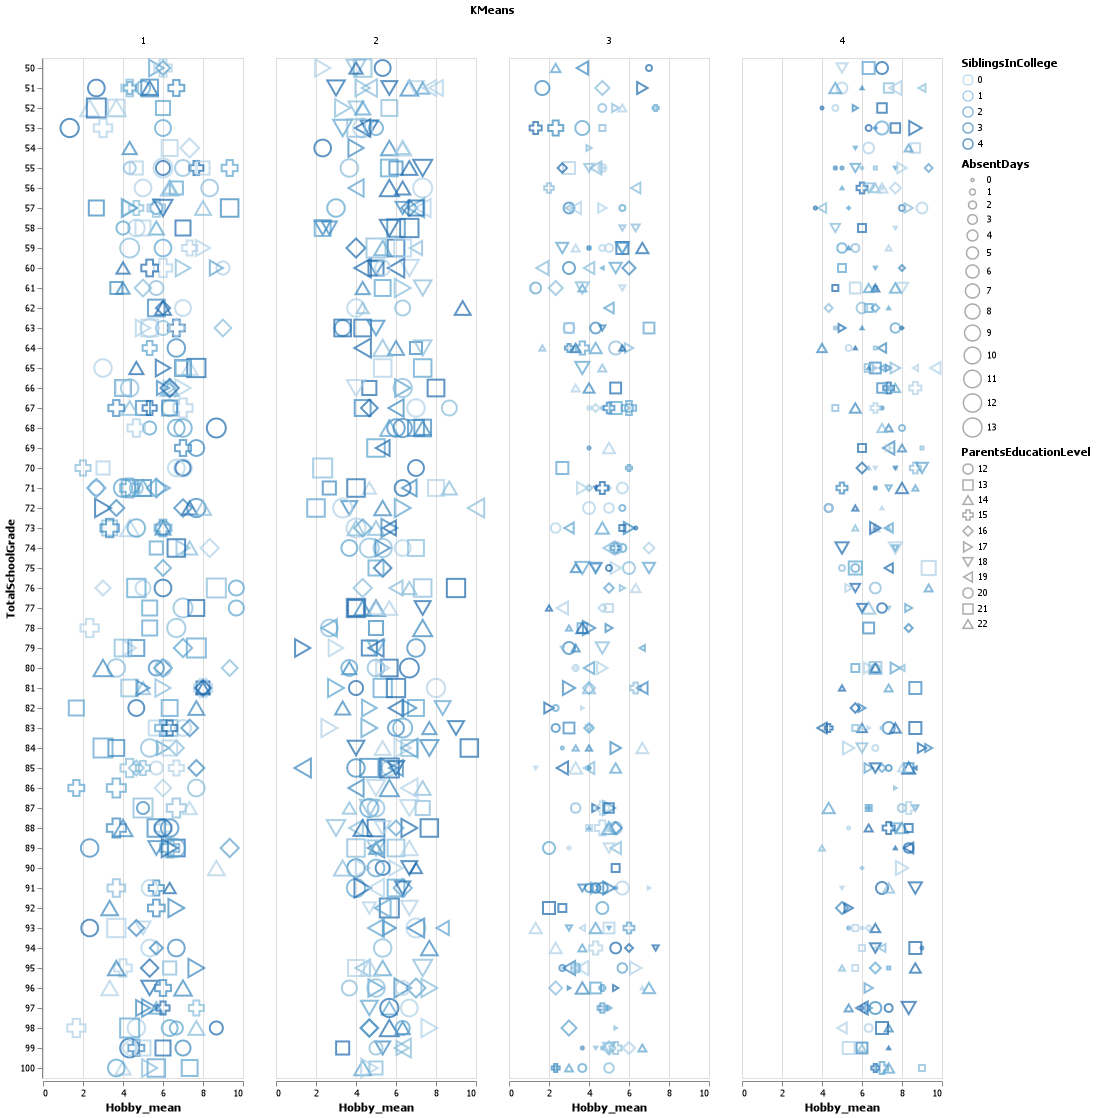

In [6]:
dfHighSchoolStudentsKmeans |>
@vlplot( :point,
    x = :Hobby_mean,
    y = :"TotalSchoolGrade:o",
    size   = :"AbsentDays:o", 
    color  = :"SiblingsInCollege:o", 
    shape  = :"ParentsEducationLevel:n", 
    column = :"KMeans:n")

Let us define cluster 1 to 4 to “strong” students, “good” students, “fair” students, and “at-risk” students. Our data set is random so it is not surprising cluster separation is not very clear. Yet, there are still some graphical data patterns to guide the student classification. Below we compute some averages to clarify further.  Cluster 3 and 4 have less absent days making them the "good" or "strong" students. Cluster 1 has the most absents making them the “at-risk” students.  The clusters have similar school grades because the grades are random.  Do you agree?

* Cluster 1 is the “at-risk” students
* Cluster 2 is the "fair" students
* Cluster 3 is the "good" students
* Cluster 4 is the "strong" students

Interestingly, this is the same order that K means along with PCA defined the four clusters.

In [7]:
by(dfHighSchoolStudentsKmeans, :KMeans, 
                    :AbsentDays            => mean,
                    :TotalSchoolGrade      => mean,
                    :Hobby_mean            => mean,           
                    :Social_mean           => mean,
                    :ParentsEducationLevel => mode,
                    :SiblingsInCollege     => mean) |> @select(1:7)

KMeans,AbsentDays_mean,TotalSchoolGrade_mean,Hobby_mean_mean,Social_mean_mean,ParentsEducationLevel_mode,SiblingsInCollege_mean
"CategoricalValue{Int64,UInt32} 1",9.43678,74.4215,5.65517,5.21839,"CategoricalValue{Int64,UInt32} 12 (1/11)",1.8659
"CategoricalValue{Int64,UInt32} 2",10.1185,75.3,5.44691,5.71481,"CategoricalValue{Int64,UInt32} 21 (10/11)",2.11481
"CategoricalValue{Int64,UInt32} 3",3.26522,76.6565,4.37391,5.68261,"CategoricalValue{Int64,UInt32} 17 (6/11)",1.76522
"CategoricalValue{Int64,UInt32} 4",2.42678,73.9582,6.72803,5.32636,"CategoricalValue{Int64,UInt32} 22 (11/11)",2.07113


## While Attending the Community College

The above shows a four-way classification of high school students who are applying to the community college.  A nice colorful graph showing the four clusters defined by the K means model.  The  community college staff needs a way to monitor all the students while in the community college.  Let's give them a machine learning model to do so. We need a machine learning model that is easy to understand. Also, the model should be easy to share among community college teachers and staff.

We feed the four K means classification to our next machine learning model. Our next model is the binary Support Vector Machine (SVM).  Let us keep more attention to “fair”,  “at-risk” students than to “strong” and “good” students.  The goal is to detect as early as possible students who are in need.  The Support Vector Machine (SVM) classifies which community college students need help or not.  SVM is effective in high dimensional spaces.

The community college runs the binary SVM model at least every month.  Ideally, we should run the SVM classifier weekly. The training data for the SVM model is updated before each run.  In this matter, the community college closely tracks the needs of their students. 

Now it is time to create the random data set.  High schools students who were accepted to the community collage are chosen randomly.  Just like K means, SVM requires scientic types for each column., and normalized data.  An important factor is the difference between last semester total grade and the current sementer total grade so far.  Is the student doing better this semester than last semester?  Community college students working part time to pay for school might need more attention for the college.   Lastly, high school related columns are dropped and community college related collumns are added to data set. 

In [8]:
dfCommunityCollegeStudents = copy(dfHighSchoolStudentsKmeans)
rng = MersenneTwister(20200229)
dfCommunityCollegeStudents.Accepted = bitrand(rng, nStudents)
filter!(row -> row[:Accepted] == true, dfCommunityCollegeStudents);
        
select!(dfCommunityCollegeStudents,[
        :ParentsEducationLevel,
        :ParentsEmploymentStatus,
        :SingleParentFamily,         
        :ZipCode,   
        :SiblingsInCollege,          
        :AbsentDays,                 
        :TotalSchoolGrade,           
        :CommunityService,           
        :KMeans
        ])

function randomVector( size, range)
     return [rand(range) for r in 1:size]
end

dfCommunityCollegeStudents.StudentId = [i for i in 1:nrow(dfCommunityCollegeStudents)]	
dfCommunityCollegeStudents.AbsentDays = randomVector( nrow(dfCommunityCollegeStudents), collect(0:13))
dfCommunityCollegeStudents.TotalSchoolGrade = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))          
dfCommunityCollegeStudents.CommunityService = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))
dfCommunityCollegeStudents.TotalMajorGrade = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))
dfCommunityCollegeStudents.TotalNonMajorGrade = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))
dfCommunityCollegeStudents.Major = categorical(randomVector( nrow(dfCommunityCollegeStudents), collect(1:8)))
dfCommunityCollegeStudents.CounselorVisits = randomVector( nrow(dfCommunityCollegeStudents), collect(0:15))
dfCommunityCollegeStudents.TeacherOfficeHoursVisits = randomVector( nrow(dfCommunityCollegeStudents), collect(0:15))
dfCommunityCollegeStudents.ClassesUntilGraduation = randomVector( nrow(dfCommunityCollegeStudents), collect(0:16))
dfCommunityCollegeStudents.ParttimeWork = categorical(randomVector( nrow(dfCommunityCollegeStudents), collect(0:1)))
dfCommunityCollegeStudents.TotalPreviousSemesterGrade = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))
dfCommunityCollegeStudents.TotatCurrentSemesterGrade = randomVector( nrow(dfCommunityCollegeStudents), collect(50:100))
dfCommunityCollegeStudents.SemesterGradeDiffernce = dfCommunityCollegeStudents.TotatCurrentSemesterGrade .- dfCommunityCollegeStudents.TotalPreviousSemesterGrade

dfCommunityCollegeStudentsScientific = coerce(dfCommunityCollegeStudents, 
    :TotalSchoolGrade           => Continuous,
    :TotalMajorGrade            => Continuous,
    :TotalNonMajorGrade         => Continuous,
    :TotalPreviousSemesterGrade => Continuous,
    :TotatCurrentSemesterGrade  => Continuous,
    :SemesterGradeDiffernce     => Continuous)    

schema(dfCommunityCollegeStudentsScientific)

┌────────────────────────────┬────────────────────────────────┬───────────────────┐
│ _.names                    │ _.types                        │ _.scitypes        │
├────────────────────────────┼────────────────────────────────┼───────────────────┤
│ ParentsEducationLevel      │ CategoricalValue{Int64,UInt32} │ OrderedFactor{11} │
│ ParentsEmploymentStatus    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2}  │
│ SingleParentFamily         │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2}  │
│ ZipCode                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5}  │
│ SiblingsInCollege          │ Int64                          │ Count             │
│ AbsentDays                 │ Int64                          │ Count             │
│ TotalSchoolGrade           │ Float64                        │ Continuous        │
│ CommunityService           │ Int64                          │ Count             │
│ KMeans                     │ CategoricalValue{Int64,UInt32} │ Multiclass{4

K means is a unsupervised machine learning model.  K means classifies data by grouping similar features.  On the other hand, SVM is a supervised machine learning model.  SVM requires already known answers to predict future answers.  The previously known answers is the train subset.  The community college administrators kept track of students in need in previous semesters.  Then, they use that previous data to train the current semester's SVM model.  They also incorporate the current semester data so far before running the SVM model.  

In this lab, we must make up the training subset for the SVM machine learning model.  We are using SVM machine learning model as a binary classifier.   Thus, we need to make up binary answers.  Let's use K means to classify some of the students in the community college.  Divide the data into two halves.  Train the SVM model with the K means classified half.  Then,  predict with the SVM model the other half.          

Jason Brownlee says that a [semi-supervised model](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms) is where some of the previous answers are not known.  In this case, "a mixture of supervised and unsupervised techniques can be used.  Many real world machine learning problems fall into this area. This is because it can be expensive or time-consuming to label data as it may require access to domain experts. Whereas unlabeled data is cheap and easy to collect and store."

In [9]:
dfCommunityCollegeStudentsSVM = copy(dfCommunityCollegeStudentsScientific)
dfCommunityCollegeStudentsSVM.SVM = categorical(randomVector( nrow(dfCommunityCollegeStudentsSVM), collect(1:2)))

@pipeline SPCA2(std = Standardizer(),
                pca = PCA(),
                hot = OneHotEncoder(),
                km  = KMeans(k=2))
X = select(dfCommunityCollegeStudentsSVM, Not([:SVM,:StudentId]))
y = dfCommunityCollegeStudentsSVM.SVM

train, pred = partition(eachindex(y), 0.5, shuffle=true, rng=20200303)

pipe = SPCA2()
Kmeans = machine(pipe, X)
fit!(Kmeans, rows=train)

assignments = report(Kmeans).reports[1].assignments
dfCommunityCollegeStudentsSVM[train,:SVM] = categorical(assignments)

r  = report(Kmeans).reports[3]  # 2 or 3
cs = cumsum(r.principalvars ./ r.tvar)

println("Cumulative Variance Explained: ", cs, "\n")
println("K means assignments:  ", assignments)
fitted_params(Kmeans) |> pprint

┌ Info: Training Machine{SPCA2} @ 1…12.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{Standardizer} @ 1…71.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{PCA} @ 1…65.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{OneHotEncoder} @ 1…18.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


Cumulative Variance Explained: [0.6604593110631986, 0.7435901528049105, 0.8193999114330253, 0.877232206130644, 0.9211605775552911, 0.9487999062697445, 0.9651148730994774, 0.9714650465880555, 0.9774622911659175, 0.9827859915534435, 0.9864627536478707, 0.9897076069830387, 0.9925510958793523]

K means assignments:  

┌ Info: Training NodalMachine{KMeans} @ 7…51.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


[1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2]
(machines = [NodalMachine{KMeans} @ 7…51,
             NodalMachine{OneHotEncoder} @ 1…18,
             NodalMachine{PCA} @ 1…65,
             NodalMachine{Standardizer} @ 1…71],
 fitted_params =
     [(centers =
           [12.33948013543522 -13.097167512172485; -0.09193158408960776 0.0975765

Very quickly, we are ready to precict the students that need extra help from the community college.  Impressive, our binary SVM is about 100% accurate on the training data without any model tuning.  But, is the model overfitting? One (like the reader) needs to create a seperate test dataset to find out.  

In [10]:
X = convert(Matrix, select(dfCommunityCollegeStudentsSVM, Not([:SVM,:StudentId])))
X = MLJ.table(X)
y = dfCommunityCollegeStudentsSVM.SVM

@pipeline SSVM(std = Standardizer(), 
               hot = OneHotEncoder(), 
               svc = SVC()) 
pipe = SSVM()

SVM = machine(pipe, X, y)
fit!(SVM, rows=train)

ypred = predict(SVM, rows=train)
println("Misclassification Rate:  ", misclassification_rate(ypred, y[train]))

assignments = predict(SVM, rows=pred)
dfCommunityCollegeStudentsSVM[pred,:SVM] = categorical(assignments)
report(SVM) |> pprint

┌ Info: Training Machine{SSVM} @ 4…34.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{Standardizer} @ 3…83.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{OneHotEncoder} @ 1…15.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{SVC} @ 1…28.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


Misclassification Rate:  0.0
(machines = [NodalMachine{SVC} @ 1…28,
             NodalMachine{OneHotEncoder} @ 1…15,
             NodalMachine{Standardizer} @ 3…83],
 reports =
     [(gamma = 0.05263157894736842,),
      (features_to_be_encoded = [],
       new_features = [:x1,
                       :x2,
                       :x3,
                       :x4,
                       :x5,
                       :x6,
                       :x7,
                       :x8,
                       :x9,
                       :x10,
                       :x11,
                       :x12,
                       :x13,
                       :x14,
                       :x15,
                       :x16,
                       :x17,
                       :x18,
                       :x19]),
      (features_fit =
           Symbol[:x15, :x17, :x8, :x12, :x16, :x18, :x7, :x19, :x9, :x6, :x5, :x3, :x10, :x14, :x1, :x2, :x13, :x11, :x4],)])

Let us graph the predictions as well.  Let SVM = 1 be community college students in need. 

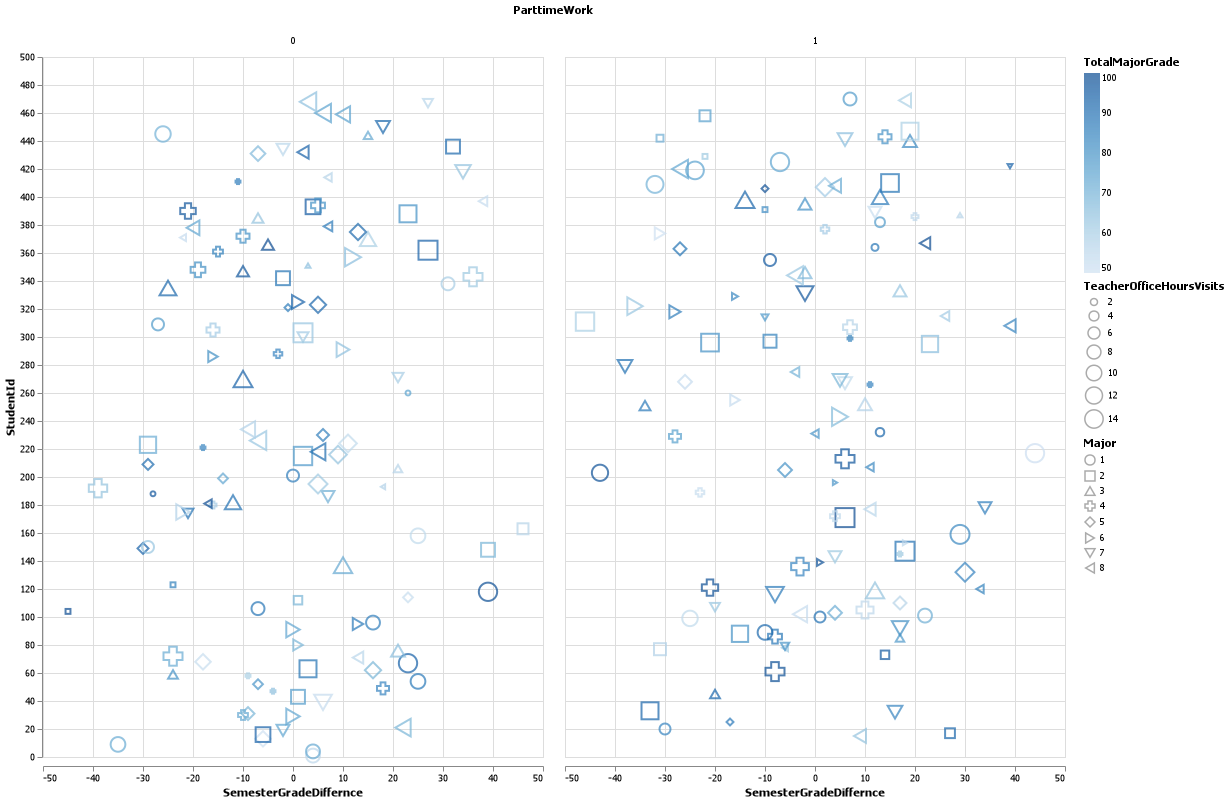

In [11]:
dfCommunityCollegeStudentsSVM |> @filter(_.SVM == 1) |>
@vlplot( :point,
    x = :SemesterGradeDiffernce,
    y = :StudentId,    
    size   = :TeacherOfficeHoursVisits,
    color  = :TotalMajorGrade,   
    shape  = :"Major:n",
    column = :"ParttimeWork:n",
    width  = 500,
    height = 700)

## After Graduating from the Community College

The above is a binary classification of the community college students that need or not.  A nice colorful graph showing the student separation defined by the SVM machine learning model.  Let us contact students in need and offer them extra help from their professors and community college staff.  

In addition, the community college also likes to track students after graduation.  Graduates who do good at the workplace usually were also good college community students.  The administrators would interpret the results SVM model taking into account the characteristics of the good workers. Even more critical, we need to study graduates with unsuccessful careers.  Their characteristics should be incorporated into the “While attending community college” model to increase the students’ career guidance.  The consequence is that the community college would train students earlier on workplace skills.  Let's use the Random tree machine learning model to track graduates. 

Let us keep track of our graduates for five years.  We must consider data quality again.  The community college is collecting graduate information via online surveys, LinkedIn profiles, Facebook pages, etc. The kind of data is not structured in a consistent way.  A Random Forest model has an effective method for estimating missing data and maintains accuracy when large proportions of the data are missing.  The Random Forest algorithm has methods for balancing errors in datasets where classes are imbalanced.  Here, a Random Forest machine learning model classifies the graduates at the workforce.  It is a scale from 1 to 10 where 10 is great at the workforce while 1 is needs improvement.  The community college runs the Random Forest model at least monthly.  

Now it is time to create the random data set.  Just like K means and SVM models, Random Forest requires scientific types for each column.  Random Forest is a supervised model that needs training like the SVM model. There are some important predictors to consider for the last five years for each community college graduate. We include employment duration, number of different jobs, number of promotions, if attending university, and kind of employers. The less unemployment duration the better. If the number of jobs is low and the number of promotions is high then that is fantastic.  Let us add the predictors to the college student dataset.

In [12]:
dfCommunityCollegeGraduatesRandomForest = copy(dfCommunityCollegeStudentsSVM)

select!(dfCommunityCollegeGraduatesRandomForest,[
        :StudentId,
        :ParentsEmploymentStatus,                     
        :KMeans,
        :SVM])

dfCommunityCollegeGraduatesRandomForest.EmploymentDuration = randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(0:5))
dfCommunityCollegeGraduatesRandomForest.NumberOfJobs       = randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(0:10))
dfCommunityCollegeGraduatesRandomForest.NumberOfPromotions = randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(0:10))
dfCommunityCollegeGraduatesRandomForest.AnyUniversity      = categorical(randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(0:1)))
dfCommunityCollegeGraduatesRandomForest.EmployerKind       = categorical(randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(0:5)))

schema(dfCommunityCollegeGraduatesRandomForest)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ StudentId               │ Int64                          │ Count            │
│ ParentsEmploymentStatus │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ KMeans                  │ CategoricalValue{Int64,UInt32} │ Multiclass{4}    │
│ SVM                     │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ EmploymentDuration      │ Int64                          │ Count            │
│ NumberOfJobs            │ Int64                          │ Count            │
│ NumberOfPromotions      │ Int64                          │ Count            │
│ AnyUniversity           │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ EmployerKind            │ CategoricalValue{Int64,UInt32} │ Multiclass{6}    │
└─────────────────────────┴─────────────

K means classifier is used again to define the training dataset for the Random Forest classifier.

In [13]:
dfCommunityCollegeGraduatesRandomForest.RandomForest = categorical(randomVector( nrow(dfCommunityCollegeGraduatesRandomForest), collect(1:10)))

@pipeline SPCA10(std = Standardizer(),
                 pca = PCA(),
                 hot = OneHotEncoder(),
                 km  = KMeans(k=10))
X = select(dfCommunityCollegeGraduatesRandomForest, Not([:RandomForest, :StudentId]))

X = coerce( X, 
    :EmploymentDuration   => Continuous,
    :NumberOfJobs         => Continuous,
    :NumberOfPromotions   => Continuous)
y = dfCommunityCollegeGraduatesRandomForest.RandomForest

train, pred = partition(eachindex(y), 0.5, shuffle=true, rng=20200304)
pipe = SPCA10()
Kmeans = machine(pipe, X)
fit!(Kmeans, rows=train)

assignments = report(Kmeans).reports[1].assignments
dfCommunityCollegeGraduatesRandomForest[train, :RandomForest] = categorical(assignments)

r  = report(Kmeans).reports[3]  # 2 or 3
cs = cumsum(r.principalvars ./ r.tvar)

println("Cumulative Variance Explained: ", cs, "\n")
println("K means assignments:  ", assignments)
fitted_params(Kmeans) |> pprint

┌ Info: Training Machine{SPCA10} @ 5…48.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{Standardizer} @ 5…71.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{PCA} @ 5…63.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164
┌ Info: Training NodalMachine{OneHotEncoder} @ 1…30.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


Cumulative Variance Explained: [0.37027466602711295, 0.5399249848418199, 0.6723102687954977, 0.7953422499203138, 0.9069771441794019, 0.9406151891180272, 0.9726823559139026, 1.0]

K means assignments:  [5, 2, 7, 4, 9, 4, 2, 2, 8, 7, 8, 3, 8, 2, 8, 4, 3, 7, 6, 4, 10, 10, 4, 6, 3, 8, 3, 6, 2, 2, 7, 4, 9,

┌ Info: Training NodalMachine{KMeans} @ 1…18.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


 1, 9, 3, 4, 2, 8, 7, 6, 10, 2, 3, 3, 5, 6, 6, 6, 4, 3, 1, 1, 4, 6, 1, 10, 3, 1, 8, 7, 4, 1, 9, 2, 8, 2, 6, 7, 4, 5, 7, 2, 2, 3, 8, 10, 2, 3, 5, 7, 3, 10, 6, 1, 9, 8, 3, 2, 2, 2, 8, 10, 4, 6, 10, 2, 3, 2, 1, 2, 5, 1, 5, 4, 2, 5, 10, 5, 3, 4, 5, 2, 8, 8, 4, 4, 10, 5, 5, 8, 4, 10, 6, 5, 6, 2, 2, 10, 6, 5, 2, 4, 9, 9, 3, 2, 1, 7, 4, 4, 4, 9, 4, 7, 3, 7, 1, 6, 5, 5, 4, 5, 8, 9, 4, 1, 3, 6, 9, 10, 3, 10, 10, 10, 2, 3, 4, 1, 7, 4, 7, 8, 1, 5, 2, 2, 5, 6, 10, 3, 5, 1, 10, 9, 2, 4, 4, 6, 10, 8, 5, 1, 10, 2, 9, 5, 7, 10, 9, 7, 6, 8, 8, 8, 1, 3, 2, 4, 3, 2, 4, 2, 5, 5, 4, 2, 8, 9, 10, 1, 9, 4, 3, 5, 3, 9, 3, 1, 4, 4, 1, 9, 9, 8]
(machines = [NodalMachine{KMeans} @ 1…18,
             NodalMachine{OneHotEncoder} @ 1…30,
             NodalMachine{PCA} @ 5…63,
             NodalMachine{Standardizer} @ 5…71],
 fitted_params =
     [(centers =
           [1.7756871776893697 -1.58977753050646 -2.2780514011211936 1.741451723851677 -1.006911442042511 -0.1268168691793585 1.8653472606513606 0.4818912289604

Very quickly, we are ready to construct the Random Forest machine learning model.  Note, there is no need for scaling, one-hot-encoders or PCA when creating a Random Forest model.  The prediction assignments are next as well.

In [14]:
X = convert(Matrix, select(dfCommunityCollegeGraduatesRandomForest, Not([:RandomForest,:StudentId])))
X = MLJ.table(X)
y = dfCommunityCollegeGraduatesRandomForest.RandomForest

RandomForest = machine( RandomForestClassifier(), X, y)
fit!(RandomForest, rows=train)

ypred = predict(RandomForest, rows=train)
ypred = mode.(ypred)
println("Misclassification Rate:  ", misclassification_rate(ypred, y[train]))

assignments = predict(RandomForest, rows=pred)
assignments = mode.(assignments)
dfCommunityCollegeGraduatesRandomForest[pred,:RandomForest] = categorical(assignments)
fitted_params(RandomForest) |> pprint

┌ Info: Training Machine{RandomForestClassifier} @ 1…49.
└ @ MLJBase C:\Users\drcxcruz\.julia\packages\MLJBase\FFnHt\src\machines.jl:164


Misclassification Rate:  0.02127659574468085
(forest =
     Ensemble of Decision Trees
Trees:      10
Avg Leaves: 35.3
Avg Depth:  7.4,)

Let us graph the predictions.  Remember that RandomForrest = 1 is the group of community college graduates with poor workforce results.  The RandomForrest = 10 is the group that is doing great in the workforce.  AnyUniversity is a binary factor.

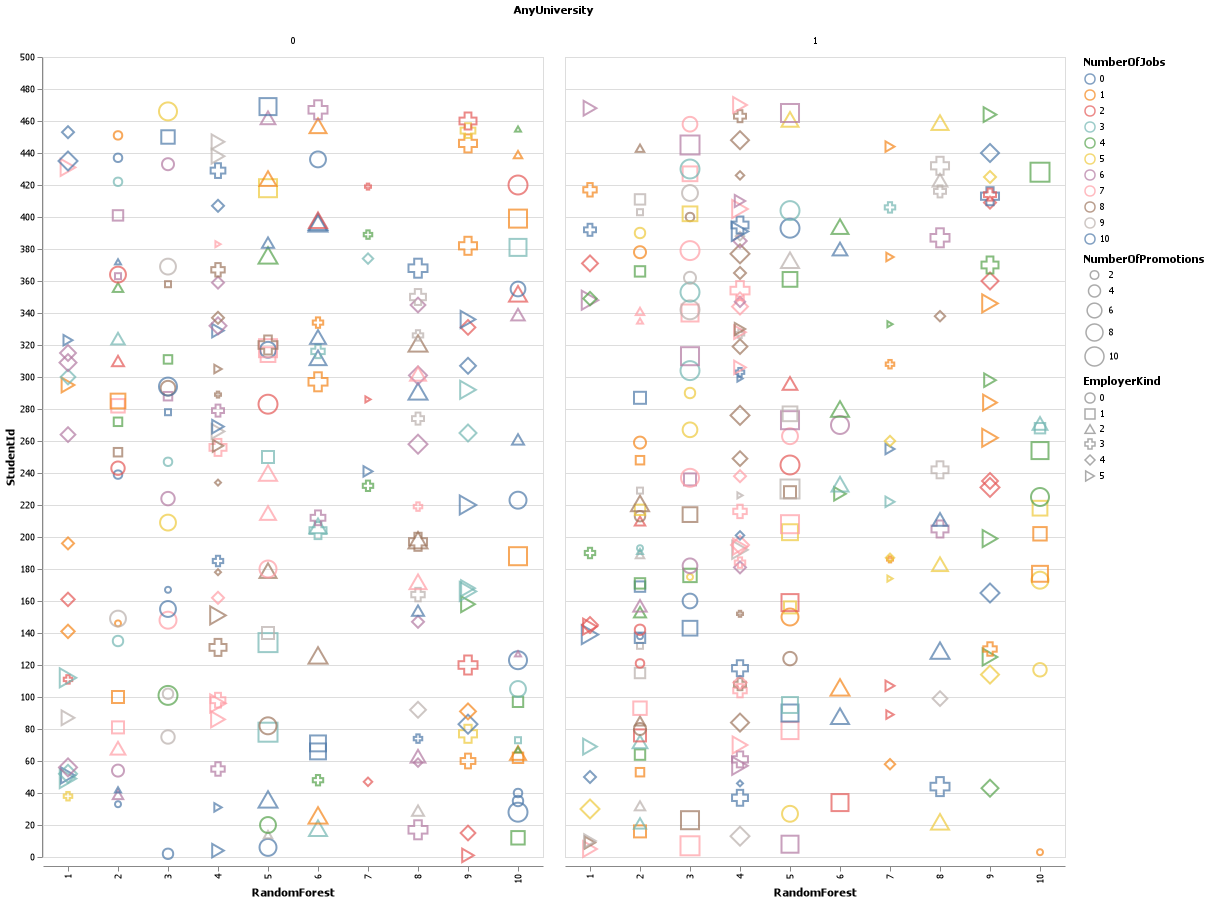

In [15]:
dfCommunityCollegeGraduatesRandomForest |>
@vlplot( :point,
    x = :"RandomForest:n",
    y = :StudentId,    
    size   = :NumberOfPromotions,             
    color  = :"NumberOfJobs:n",   
    shape  = :"EmployerKind:n",
    column = :"AnyUniversity:n",
    width  = 500,
    height = 800)

## Every Machine Learning Model Has Pros And Cons 

Let's finish this story by thinking about the three machine learning classifiers.  There are many analytical models to choose from.  Every single machine learning model has advantages and disadvantages.   Next are some the pros and cons that guided model selection in this lab.  Pros and Cons particularly important in this community college lab are highlighted in **bold**.

---
[Pros And Cons](https://www.prosancons.com/education/pros-and-cons-of-k-means-clustering) shows a good list for K means as follows.

Pros:
1. **Simple: It is easy to implement k-means and identify unknown groups of data from complex data sets. The results are presented in an easy and simple manner**
2. **Flexible: K-means algorithm can easily adjust to the changes. If there are any problems, adjusting the cluster segment will allow changes to easily occur on the algorithm**
3. **Suitable in a large dataset: K-means is suitable for a large number of datasets and it’s computed much faster than the smaller dataset. It can also produce higher clusters**
4. Efficient: The algorithm used is good at segmenting the large data set. Its efficiency depends on the shape of the clusters. K-means work well in hyper-spherical clusters
5. Time complexity: K-means segmentation is linear in the number of data objects thus increasing execution time. It doesn’t take more time in classifying similar characteristics in data like hierarchical algorithms
6. Tight clusters: Compared to hierarchical algorithms, k-means produce tighter clusters especially with globular clusters
7. **Easy to interpret: The results are easy to interpret. It generates cluster descriptions in a form minimized to ease understanding of the data**
8. Computation cost: Compared to using other clustering methods, a k-means clustering technique is fast and efficient in terms of its computational cost O(K*n*d)
9. Accuracy: K-means analysis improves clustering accuracy and ensures information about a particular problem domain is available. Modification of the k-means algorithm based on this information improves the accuracy of the clusters
10. Spherical clusters: This mode of clustering works great when dealing with spherical clusters. It operates with an assumption of joint distributions of features since each cluster is spherical. All the clusters features or characters have equal variance and each is independent of each other

Cons:

1. **No-optimal set of clusters: K-means doesn’t allow development of an optimal set of clusters and for effective results, you should decide on the clusters before using it**
2. **Lacks consistency: K-means clustering gives varying results on different runs of an algorithm. A random choice of cluster patterns yields different clustering results resulting in inconsistency**
3. Uniform effect: It produces cluster with uniform size even when the input data has different sizes
4. Order of values: The way in which data is ordered in building the algorithm affects the final results of the data set
5. Sensitivity to scale: Changing or rescaling the dataset either through normalization or standardization will completely change the final results
6. Crash computer: When dealing with a large dataset, conducting a dendrogram technique will crash the computer due to a lot of computational load and Ram limits
7. **Handle numerical data: K-means algorithm can be performed in numerical data only**
8. Operates in assumption: K-means clustering technique assumes that we deal with spherical clusters and each cluster has equal numbers for observations. The spherical assumptions have to be satisfied. The algorithm can’t work with clusters of unusual size
9. **Specify K-values: For K-means clustering to be effective, you have to specify the number of clusters (K) at the beginning of the algorithm**
10. Prediction issues: It is difficult to predict the k-values or the number of clusters. It is also difficult to compare the quality of the produced clusters

---
[Analytics Vidhhya](https://www.analyticsvidhya.com) and [HackingNote](https://www.hackingnote.com) have contained online posts about the pros and cons of Support Vector Machines.  [Profesional Point](http://theprofessionalspoint.blogspot.com/2019/03/advantages-and-disadvantages-of-svm.html) has its owm SVM list as well. Some of their points follow.

Pros:
1. **SVM works really well with clear margin of separation**
2. **SVM is effective in high dimensional spaces**
3. It is effective in cases where the number of dimensions is greater than the number of samples
4. It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient
5. **SVM has good theoretical guarantees regarding overfitting**
5. SVM does not suffer of multicollinearity
6. **Handles non-linear data efficiently: SVM can efficiently handle non-linear data using Kernel trick**
7. **Stability: A small change to the data does not greatly affect the hyperplane and hence the SVM. So the SVM model is stable**


Cons:

1. SVM doesn’t perform well, when we have large data set because the required training time is higher
2. It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
3. **SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation**
4. SVM can be inefficient to train, memory-intensive and annoying to run and tune
5. SVM is not for problems with many training examples
6. **Requires Feature Scaling: One must do feature scaling of variables before applying SVM**


---
[Quora.com](https://www.quora.com/What-are-the-advantages-and-disadvantages-for-a-random-forest-algorithm) discusses some pros and cons of the Random Forest model as follows.

Pros:
1. **You can train a model with a relatively small number of samples and get pretty good results**
2. The computational cost of training a random forest is quite low
3. **Random forest can solve both types of problems that is classification and regression** 
4. **It can handle thousands of input variables and identity most significant variables so it is considered as one of dimensionality reduction methods. Further, the model outputs importance of variable, which can be a very handy feature**
5. **It has an effective method for estimating missing data and maintains accuracy when large proportion of the data are missing**
6. **It has methods for balancing errors in data sets where classes are imbalanced**
7. The capability of the above can be extended to unlabeled data, leading to unsupervised clustering,data views and outlier detection
8. **A single decision tree tends to overfit the data. The process of averaging or combining the results of different decision trees helps to overcome the problem of overfitting***
9. **Random forests also do not require preparation of the input data. You do not have to scale the data**

Cons:

1. A random forest surely does a good job at classification but not as for regression problem as it does not give precise continuous nature prediction. In case of regression, it doesn't predict beyond the range in the training data, and that they may over fit data sets that are particularly noisy
2. The prediction process using random forests is time-consuming than other algorithms
2. **Random forests also require more computational resources and are also less intuitive. When you have a large collection of decision trees it is hard to have an intuitive grasp of the relationship existing in the input data**


## Conclusion 
College and universities have used data analytics for years in their admission process.  The data analytics in this lab emphasises what happens after the student is admitted to the community college.  Open source programing languages like Julia along packages like MLJ and VegaLite reduce the cost of data analytics compared to software applications such as SAS.

This jupyter lab showcases [MLJ](https://alan-turing-institute.github.io/MLJTutorials) which is a great machine learning framework.  We implement three machine learning models:  [K means](https://juliastats.org/Clustering.jl/stable/kmeans.html) with [PCA](https://multivariatestatsjl.readthedocs.io/en/stable/index.html), binary [Support Vector Machine](https://www.csie.ntu.edu.tw/~cjlin/libsvm), and [Random Forrest](https://pkg.julialang.org/docs/DecisionTree/pEDeB/0.8.1) with MLJ in [Julia](https://julialang.org) 1.3.1. The three classifiers are chained because the output of one is used as part of the input of another classifier.  It is the author's unique modeling design. [VegaLite](https://www.queryverse.org/VegaLite.jl/stable) Julia package is used to graph the machine model results.   The three machine learning models help a community college to improve student experience and increase retention rate.  In this matter, the unemployment rate is reduced and state/federal tax revenue is increased as the graduates start their new jobs.    

The assumptions here are from my familiarity with the United States education system.  Some of the details and implementation might not apply to other countries.  Yet, a similar machine modeling is applicable to many community colleges around the world.

# About the Author

Clarman Cruz completed his BS/MS in Computer Science from State University of New York at Stony Brook/Albany. He has more than 15 years technology experience in the banking industry. He is completing on May 2020 his edX MicroMasters in Analytics from Georgia Tech.